# Prediction of Online Shoppers’ Purchasing Intention

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

In [53]:
df = pd.read_csv('online_shoppers_intention.csv')

In [54]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [55]:
df.PageValues

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
12325    12.241717
12326     0.000000
12327     0.000000
12328     0.000000
12329     0.000000
Name: PageValues, Length: 12330, dtype: float64

# Data Cleaning

In [56]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [57]:
# Re-formatting features
df.Weekend = df.Weekend.astype(int)
df.Revenue = df.Revenue.astype(int)

In [58]:
df.Revenue.value_counts()

0    10422
1     1908
Name: Revenue, dtype: int64

In [59]:
# Dropping rows where the type of visitors is 'other' (only 75 instances)
df = df.drop(df.loc[df['VisitorType']=='Other'].index, axis=0).reset_index(drop=True)

In [60]:
df.shape

(12245, 18)

In [61]:
def calculate_IQR(column):
    IQR = column.quantile(0.75) - column.quantile(0.25)
    return IQR

def find_outliers(column):
    IQR = calculate_IQR(column)
    lower_whisker = column.quantile(0.25) - 1.6 * IQR 
    higher_whisker = column.quantile(0.75) + 1.6 * IQR 
    outliers_list = []
    for index in list(column.index):
        if column[index] < lower_whisker:
            outliers_list.append([index])
        elif column[index] > higher_whisker:
            outliers_list.append(column[index])
    return outliers_list

def where_outliers(column):
    IQR = calculate_IQR(column)
    lower_whisker = column.quantile(0.25) - 1.6 * IQR 
    higher_whisker = column.quantile(0.75) + 1.6 * IQR 
    outliers_list = [idx for idx in range(len(column)) if column[idx] < lower_whisker or column[idx] > higher_whisker]
    return outliers_list

def find_extreme_values(column):
    extreme_values = []
    IQR = calculate_IQR(column)
    for index in list(column.index):
        if column[index] < column.quantile(0.05):
            extreme_values.append(column[index])
        elif column[index] >  column.quantile(0.95):
            extreme_values.append(column[index])
    return extreme_values

In [62]:
df['Administrative_Duration_outlier'] = df.index.isin(where_outliers(df.Administrative_Duration))
df['Informational_Duration_outlier'] = df.index.isin(where_outliers(df.Informational_Duration))
df['ProductRelated_Duration_outlier'] = df.index.isin(where_outliers(df.ProductRelated_Duration))

df['outlier'] = df['Administrative_Duration_outlier'] | df['Informational_Duration_outlier'] | df['ProductRelated_Duration_outlier']

In [63]:
df = df.loc[df.outlier == False]

In [64]:
df = df.drop(['Administrative_Duration_outlier', 'Informational_Duration_outlier', 'ProductRelated_Duration_outlier', 'outlier'], axis=1)

# Exploratory Data Analysis

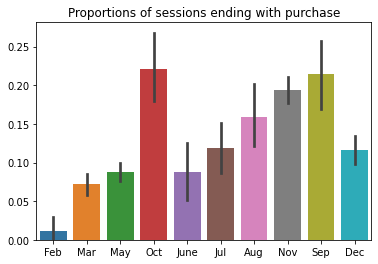

In [22]:
sns.barplot(x=df.Month, y=df.Revenue)
plt.title('Proportions of sessions ending with purchase')
plt.xlabel('')
plt.ylabel('')
plt.show()

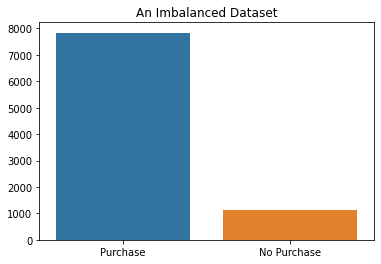

In [65]:
sns.countplot(x = df.Revenue)
plt.title('An Imbalanced Dataset')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0, 1], ['Purchase', 'No Purchase'])
plt.show()

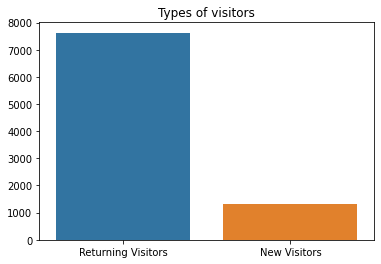

In [66]:
visitors = pd.DataFrame(df.VisitorType.value_counts())
visitors

sns.countplot(x = df.VisitorType)
plt.title('Types of visitors')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0, 1], ['Returning Visitors', 'New Visitors'])
plt.show()

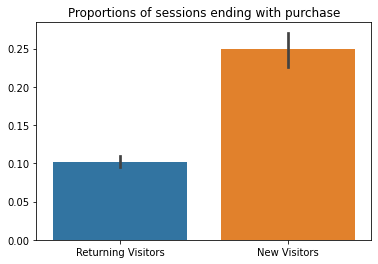

In [67]:
sns.barplot(x=df.VisitorType, y=df.Revenue,)
plt.title('Proportions of sessions ending with purchase')
plt.xlabel('')
plt.ylabel('')
plt.xticks([0, 1], ['Returning Visitors', 'New Visitors'])
plt.show()

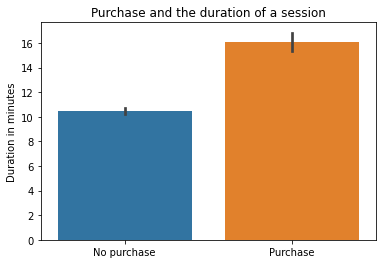

In [68]:
sns.barplot(x=df.Revenue, y=df.ProductRelated_Duration/60)
plt.title('Purchase and the duration of a session')
plt.xlabel('')
plt.xticks([0, 1], ['No purchase', 'Purchase'])
plt.ylabel('Duration in minutes')
plt.show()

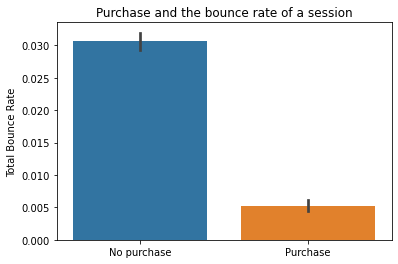

In [69]:
sns.barplot(x=df.Revenue,y= df.BounceRates)
plt.title('Purchase and the bounce rate of a session')
plt.xlabel('')
plt.xticks([0, 1], ['No purchase', 'Purchase'])
plt.ylabel('Total Bounce Rate')
plt.show()

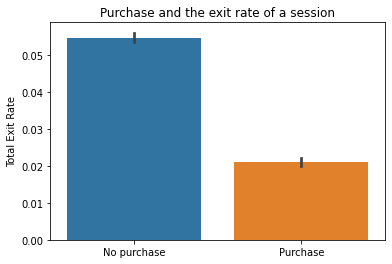

In [70]:
sns.barplot(x=df.Revenue, y=df.ExitRates)
plt.title('Purchase and the exit rate of a session')
plt.xlabel('')
plt.xticks([0, 1], ['No purchase', 'Purchase'])
plt.ylabel('Total Exit Rate')
plt.show()

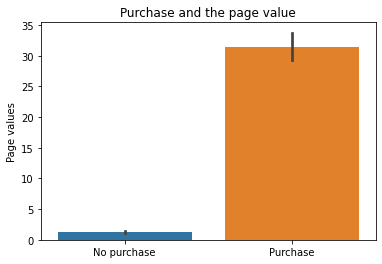

In [71]:
sns.barplot(x=df.Revenue, y=df.PageValues)
plt.title('Purchase and the page value')
plt.xlabel('')
plt.xticks([0, 1], ['No purchase', 'Purchase'])
plt.ylabel('Page values')
plt.show()

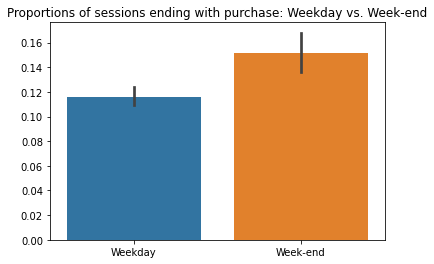

In [72]:
sns.barplot(x=df.Weekend, y=df.Revenue)
plt.title('Proportions of sessions ending with purchase: Weekday vs. Week-end')
plt.xlabel('')
plt.xticks([0, 1], ['Weekday', 'Week-end'])
plt.ylabel('')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


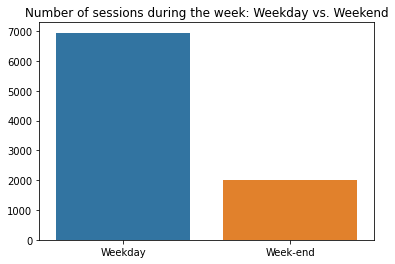

In [75]:
g = sns.countplot(df.Weekend.apply(lambda x: 'Weekday' if x==0 else 'Week-end'))
plt.title('Number of sessions during the week: Weekday vs. Weekend')
plt.xlabel('')
plt.ylabel('')
plt.show()



# Modelling 

## Pre-processing

In [79]:
cols = list(df.columns) # all columns
cols_to_not_rescale = ['Month', 'VisitorType', 'Weekend', 'Revenue', 'SpecialDay', 'BounceRates', 'ExitRates'] # columns we do not want to rescale
cols_to_rescale = list(set(cols) - set(cols_to_not_rescale)) # columns we want to rescale

In [80]:
dummies = ['VisitorType', 'Month']

dum = pd.get_dummies(df[dummies], dummies)
df = pd.concat([df, dum], axis=1)
df.drop(dummies, axis=1, inplace=True)

In [81]:
scaler = StandardScaler() # define scaler (MinMax or Standard)

df[cols_to_rescale] = scaler.fit_transform(df[cols_to_rescale])

In [82]:
#df_orig = df.copy()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Revenue',axis=1),
                                                  df.Revenue,
                                                  test_size=1/3,
                                                  random_state=2000000)

## Recursive Features Elimination

In [123]:
# RFE
model=LogisticRegression(max_iter=1e8, class_weight='balanced')
selector = RFE(model, n_features_to_select=10, step=1)
selector = selector.fit(X_train,y_train)

In [124]:
# Our best features
best_feature_indices = [idx for idx in range(len(selector.support_)) if selector.support_[idx]]
list(df.drop('Revenue',axis=1).columns[best_feature_indices])

['BounceRates',
 'ExitRates',
 'PageValues',
 'VisitorType_Returning_Visitor',
 'Month_Feb',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep']

In [125]:
df_all_features = df.drop('Revenue', axis=1)
df_best_features = df[list(df.drop('Revenue',axis=1).columns[best_feature_indices])]

In [126]:
X_train, X_test, y_train, y_test = train_test_split(df_all_features,
                                                  df.Revenue,
                                                  test_size=1/3,
                                                  random_state=2000000)

## Logistic Regression Model

In [127]:
# 1) Logistic Regression with all_features (no use of the best features from RFE)
model=LogisticRegression(max_iter=1e8, class_weight='balanced')
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
acc=accuracy_score(y_test,y_pred)
pr=precision_score(y_test,y_pred)
rec=recall_score(y_test,y_pred)
print('Acc: %s, prec: %s, rec: %s' % (acc, pr, rec))

Acc: 0.902782433791485, prec: 0.5909090909090909, rec: 0.7827225130890052


In [128]:
#Initialization with all features (no use of the best features from RFE):
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(df_all_features,
                                                  df.Revenue,
                                                  test_size=1/3,
                                                  random_state=42)

precision = []
accuracy = []
recall = []

#Incrementing the number of features used by the model
for k in range(1,15,1):
    print('Round: k=', k)
    model=LogisticRegression(max_iter=1e8, class_weight='balanced')
    selector = RFE(model, n_features_to_select=k, step=1)
    selector = selector.fit(X_train_orig, y_train)
    
    best_feature_indices = [idx for idx in range(len(selector.support_)) if selector.support_[idx]]
    df_best_features = df[list(df.drop('Revenue',axis=1).columns[best_feature_indices])]
    
    X_train, X_test, y_train, y_test = train_test_split(df_best_features,
                                                  df.Revenue,
                                                  test_size=1/3,
                                                  random_state=42)
    
    model=LogisticRegression(max_iter=1e8)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    acc=accuracy_score(y_test,y_pred)
    pr=precision_score(y_test,y_pred)
    rec=recall_score(y_test,y_pred)
    
    
    recall.append(rec)
    accuracy.append(acc)
    precision.append(pr)

precision
recall
accuracy

Round: k= 1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Round: k= 2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Round: k= 3
Round: k= 4
Round: k= 5
Round: k= 6
Round: k= 7
Round: k= 8
Round: k= 9
Round: k= 10
Round: k= 11
Round: k= 12
Round: k= 13
Round: k= 14


[0.8816627556151525,
 0.8816627556151525,
 0.9232316459939658,
 0.9232316459939658,
 0.9235668789808917,
 0.9212202480724103,
 0.9228964130070398,
 0.9232316459939658,
 0.9239021119678177,
 0.9242373449547435,
 0.9242373449547435,
 0.9239021119678177,
 0.9239021119678177,
 0.9239021119678177]

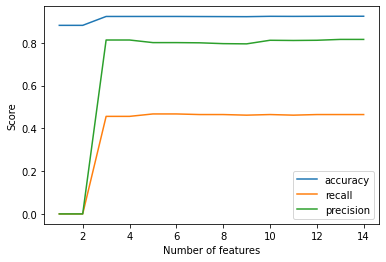

In [105]:
plt.plot([i for i in range(1,15)], accuracy)
plt.plot([i for i in range(1,15)], recall)
plt.plot([i for i in range(1,15)], precision)
plt.xlabel('Number of features')
plt.ylabel('Score')
plt.legend(['accuracy', 'recall', 'precision'], loc="lower right")
plt.show()

## Logistic Regression Balanced

In [107]:
# Using the best features used by the model
X_train, X_test, y_train, y_test = train_test_split(df_best_features,
                                                  df.Revenue,
                                                  test_size=1/3,
                                                  random_state=2000000)

In [108]:
# 2) Logistic Regression Balanced with best features selected by RFE
model=LogisticRegression(max_iter=1e8, class_weight='balanced')
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
acc=accuracy_score(y_test,y_pred)
pr=precision_score(y_test,y_pred)
rec=recall_score(y_test,y_pred)
print('Acc: %s, prec: %s, rec: %s' % (acc, pr, rec))

Acc: 0.9104927924907811, prec: 0.6252723311546841, rec: 0.7513089005235603


In [109]:
conf = confusion_matrix(y_test,y_pred)
display(conf)
f1 = f1_score(y_test,y_pred)

# accuracy : how many 'true' (pos and neg) do I get? (proportions) = (TP+TN)/TOTAL
# precision : how many 'true positives' do I get, among all the actual positives there exist = TP/(TP+FN)
# recall : how many 'true positives' do I get, among all the positives I predicted = TP/(TP+FP)
# f1 : mean btw precision and recall = (pr * rec)*2/(TP+FP)

print(f'The accuracy of my model is {acc}, the precision is {pr}, the recall is {rec}, and the mean of all scores is {f1}.')

if pr < 0.6:
    print('\nPrecision is not good enough, try to improve your model.')


array([[2429,  172],
       [  95,  287]])

The accuracy of my model is 0.9104927924907811, the precision is 0.6252723311546841, the recall is 0.7513089005235603, and the mean of all scores is 0.6825208085612365.


In [110]:
y_pred
print(np.unique(y_pred, return_counts=True))

y_test
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([2524,  459]))
(array([0, 1]), array([2601,  382]))


In [111]:
y_test = np.array(y_test)

In [112]:
right_res = []
err = []

for i in range(len(y_pred)):
    if y_pred[i] == y_test[i]:
        right_res.append(i)
    else:
        err.append(i)
        
print(f'There are {len(right_res)} right results.')
print(f'There are {len(err)} errors.')


true_pos = []
true_neg = []
false_neg = []
false_pos = []

for i in range(len(y_pred)):
    if (y_test[i]==0) and (y_pred[i]==0): #true negative (TN)
        true_neg.append(i)
    elif (y_test[i]==1) and (y_pred[i]==1): #true positive (TP)
        true_pos.append(i)
    elif (y_test[i]==0) and (y_pred[i]==1): #false positive (FP)
        false_pos.append(i)
    elif (y_test[i]==1) and (y_pred[i]==0): #false negative (FN)
        false_neg.append(i)

print(f'\nThere are {len(true_neg)} true negatives.')
print(f'There are {len(true_pos)} true positives.')
print(f'There are {len(false_neg)} false negatives errors.')
print(f'There are {len(false_pos)} false positives errors.')

There are 2716 right results.
There are 267 errors.

There are 2429 true negatives.
There are 287 true positives.
There are 95 false negatives errors.
There are 172 false positives errors.


In [98]:
conf = confusion_matrix(y_test,y_pred)
display(conf)

array([[2429,  172],
       [  95,  287]])

In [100]:
model.coef_

array([[-3.01135687, -4.40689963,  3.18498081,  0.0992059 ,  0.18723743,
        -0.20073279,  0.13769561, -1.50806923,  0.14548885, -0.57288818,
        -0.70145397,  1.09872021,  0.36634739,  0.87034767]])